In [34]:
from astropy import units as u
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

from astropy.nddata import CCDData
import ccdproc
from astropy.table import Table
from astropy.modeling import models

from matplotlib.colors import LogNorm
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.datasets import (make_random_gaussians_table,
                                make_noise_image,
                                make_gaussian_sources_image)
from photutils.psf import IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [35]:
my_coords = [(911., 1437.), (912., 854.), (1286., 1134.), (1331., 1648.), (1901., 449.), (1176., 671.),
             (946., 410.), (805., 517.), (332., 766.), (1080., 1147.)]

In [45]:
aperture = CircularAperture(my_coords, r=6.) 
annulus_aperture = CircularAnnulus(my_coords, r_in=8., r_out=12.)
annulus_aperture

<CircularAnnulus([[ 911., 1437.],
                  [ 912.,  854.],
                  [1286., 1134.],
                  [1331., 1648.],
                  [1901.,  449.],
                  [1176.,  671.],
                  [ 946.,  410.],
                  [ 805.,  517.],
                  [ 332.,  766.],
                  [1080., 1147.]], r_in=8.0, r_out=12.0)>

In [38]:
image_data = fits.getdata('wolf1346_OR_BS_FC.0003.fits')
phot_table = aperture_photometry(image_data, aperture, method='center')
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,911.0,1437.0,50151.67978848746
2,912.0,854.0,43687.58620256136
3,1286.0,1134.0,70416.83857126048
4,1331.0,1648.0,76530.98667816918
5,1901.0,449.0,58634.368946044764
6,1176.0,671.0,93709.5704651658
7,946.0,410.0,82985.98993597802
8,805.0,517.0,34862.66191182319


In [39]:
phot_annulus_table = aperture_photometry(image_data, annulus_aperture, method='center')
phot_annulus_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,911.0,1437.0,55248.833261731954
2,912.0,854.0,55085.36416438107
3,1286.0,1134.0,57294.696287285995
4,1331.0,1648.0,56475.15129630537
5,1901.0,449.0,54815.26202771648
6,1176.0,671.0,56804.498716975664
7,946.0,410.0,55758.238218130085
8,805.0,517.0,54656.225763021095


/Users/Sierra/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


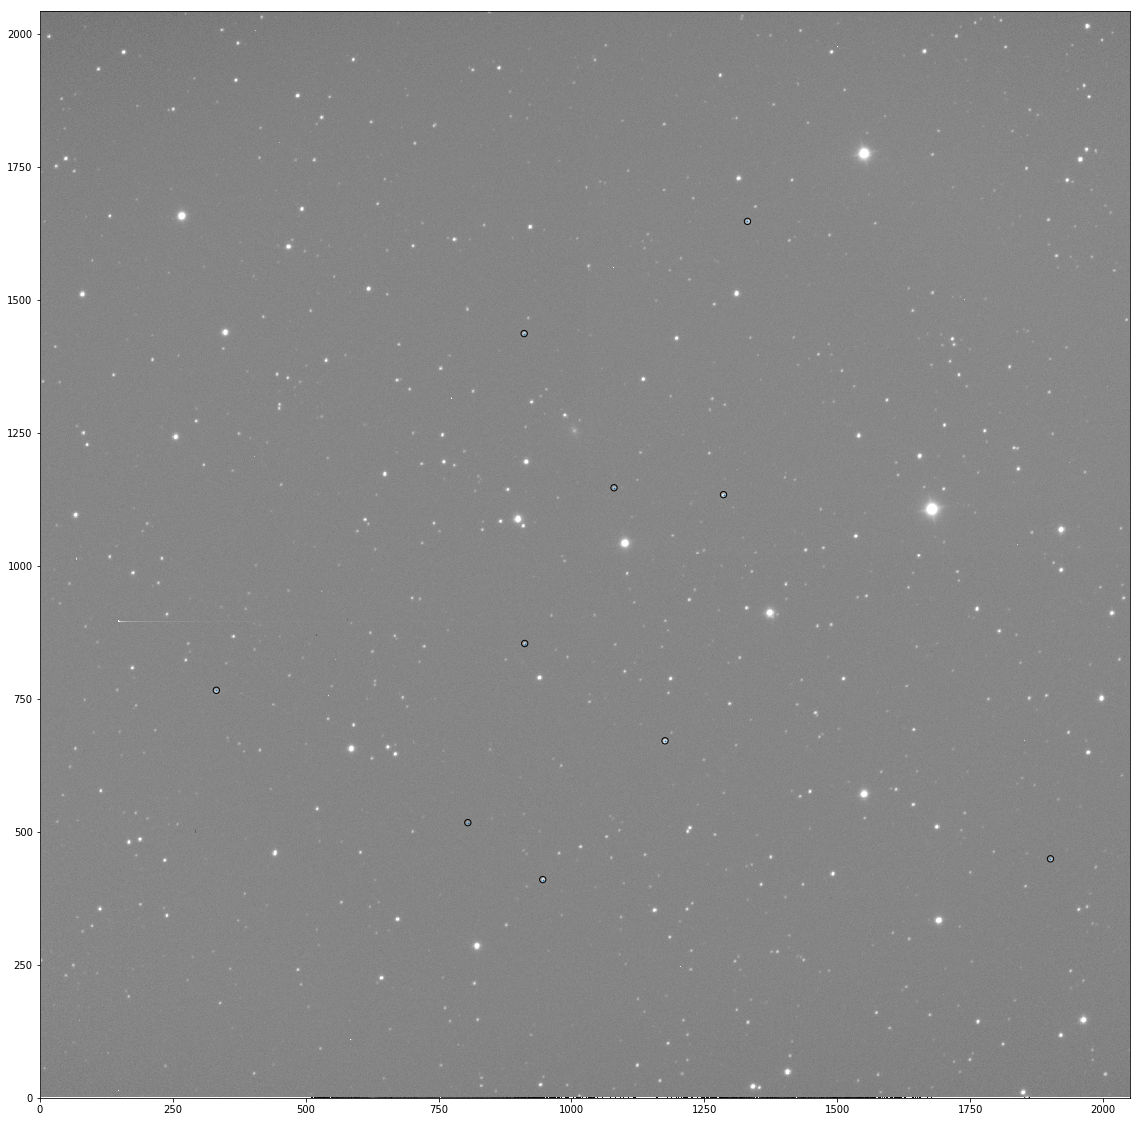

In [40]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(phot_table['xcenter'], phot_table['ycenter'], s=1)  
ax.imshow(image_data, cmap='gray', norm=LogNorm(20,2000))

CircularAperture.plot(aperture)
plt.gca().invert_yaxis()

/Users/Sierra/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


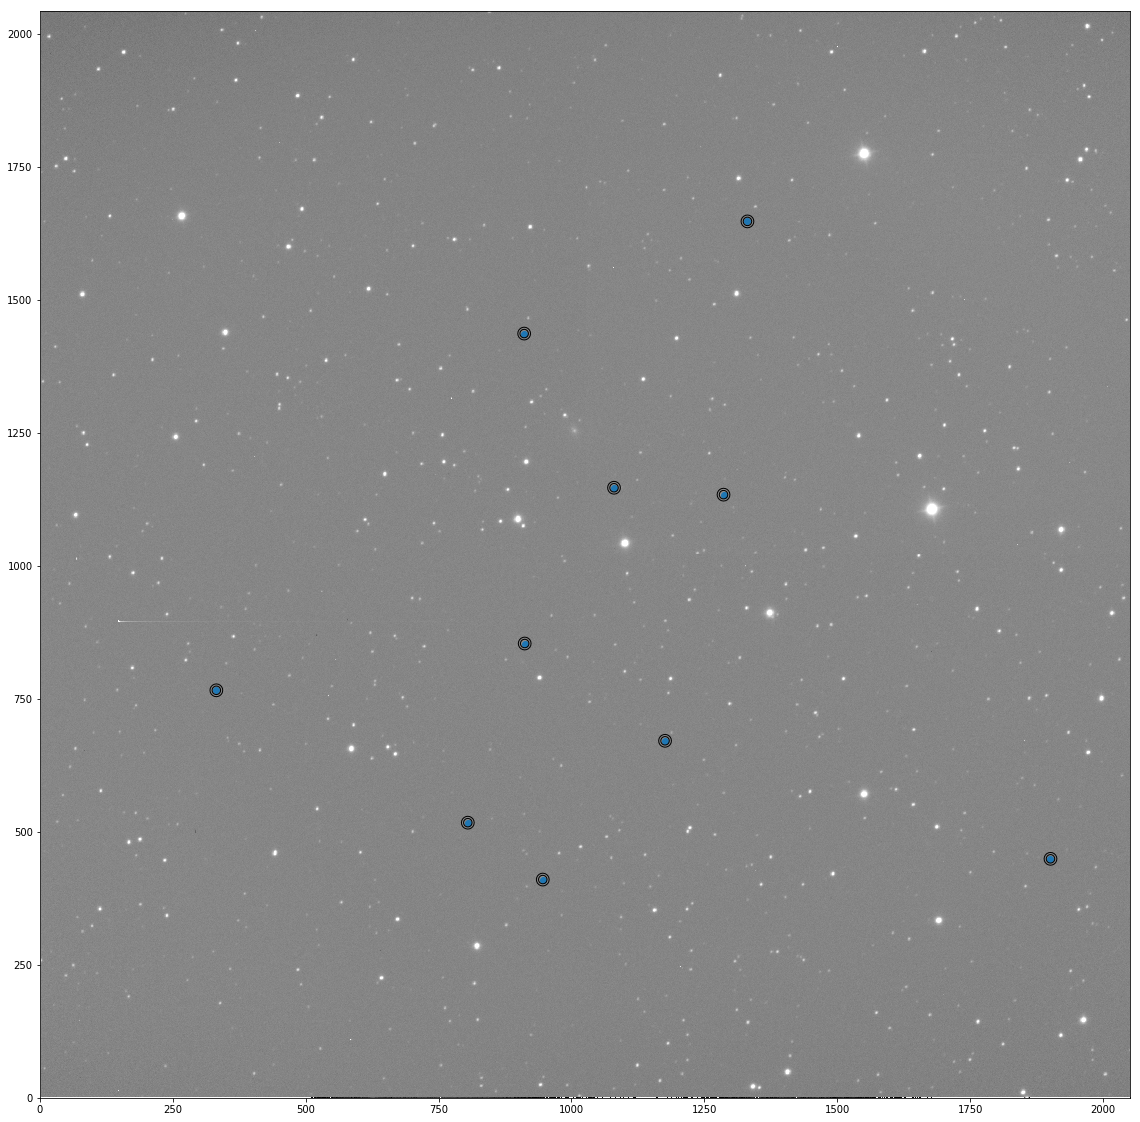

In [41]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(phot_annulus_table['xcenter'], phot_annulus_table['ycenter']) 
ax.imshow(image_data, cmap='gray', norm=LogNorm(20,2000))
CircularAnnulus.plot(annulus_aperture)
plt.gca().invert_yaxis()

In [42]:
apers = [aperture, annulus_aperture]
total_table = aperture_photometry(image_data, apers)

In [43]:
bkg_mean = total_table['aperture_sum_1'] / annulus_aperture.area()
bkg_sum = bkg_mean * aperture.area()
final_sum = total_table['aperture_sum_0'] - bkg_sum
total_table['residual_aperture_sum'] = final_sum
total_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,residual_aperture_sum
,pix,pix,,,
int64,float64,float64,float64,float64,float64
1,911.0,1437.0,51170.67930939771,56870.16926924596,25579.103138237027
2,912.0,854.0,44612.94897391452,56768.46191259734,19067.141113245718
3,1286.0,1134.0,71452.42316135802,58924.02858190663,44936.61029950004
4,1331.0,1648.0,77557.42918449666,58059.644331963194,51430.58923511323
5,1901.0,449.0,59625.98500469727,56416.77432779526,34238.4365571894
6,1176.0,671.0,94784.4845811204,58381.871475278924,68512.64241724488
7,946.0,410.0,84045.75644639226,57317.89481514186,58252.70377957843
8,805.0,517.0,35784.919997020836,56283.11936917166,10457.51628089359


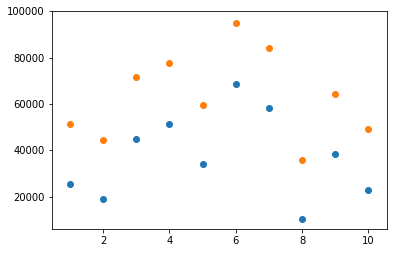

In [44]:
fig, ax = plt.subplots()
ax.scatter(total_table["id"], total_table["residual_aperture_sum"])
ax.scatter(total_table["id"], total_table["aperture_sum_0"])
plt.show()

# PSF

In [26]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

sigma_psf = 2

bkgrms = MADStdBackgroundRMS()
std = bkgrms(image_data)
iraffind = IRAFStarFinder(threshold=3.5*std, fwhm=sigma_psf*gaussian_sigma_to_fwhm, minsep_fwhm=0.01, 
                          roundhi=5.0, roundlo=-5.0, sharplo=0.0, sharphi=2.0)

daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)

from photutils.psf import IterativelySubtractedPSFPhotometry
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind, group_maker=daogroup, bkg_estimator=mmm_bkg,
                                                psf_model=psf_model, fitter=LevMarLSQFitter(),
                                                niters=1, fitshape=(11,11))

result_tab = photometry(image=image_data)
residual_image = photometry.get_residual_image()

/Users/Sierra/anaconda3/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:158: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/Sierra/anaconda3/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:159: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value
/Users/Sierra/anaconda3/lib/python3.6/site-packages/photutils/detection/findstars.py:399: RuntimeWarning: invalid value encountered in greater
  object_labels, nobjects = ndimage.label(convolved_data > threshold,
/Users/Sierra/anaconda3/lib/python3.6/site-packages/photutils/detection/core.py:241: RuntimeWarning: invalid value encountered in greater
  peak_goodmask = np.logical_and(peak_goodmask, (data > threshold))
/Users/Sierra/anaconda3/lib/python3.6/site-packages/photutils/detection/findstars.py:483: RuntimeWarning: invalid value encountered in multiply
  meansky = (imgcutout.data * skymask).sum() / nsky


In [27]:
photometry = BasicPSFPhotometry(group_maker=daogroup, bkg_estimator=mmm_bkg, psf_model=psf_model,
                                fitter=LevMarLSQFitter(), fitshape=(11,11))
pos = Table(names=['x_0', 'y_0'], data=[total_table['xcenter'], total_table['ycenter']])

result_tab = photometry(image=image_data, init_guesses=pos)
residual_image = photometry.get_residual_image()
result_tab

/Users/Sierra/anaconda3/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:158: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/Sierra/anaconda3/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:159: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,x_0_unc,y_0_unc
pix,pix,,,,,,,,,
float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
911.0,1437.0,24009.645974111267,1,1,909.7703414603824,1435.9303030393633,31082.525510540494,814.4066239145715,0.07527114033591127,0.0751808782393317
912.0,854.0,18087.51172592237,2,2,910.5884066065242,853.6574666304462,22935.108293672096,583.0904037732763,0.07321974642074297,0.07273033256621059
1286.0,1134.0,42587.08480060866,3,3,1284.81432340604,1132.7922373271183,55153.8309515811,1424.1357777474768,0.07415471702884316,0.07416594653981542
1331.0,1648.0,49101.11789398917,4,4,1330.2170712671953,1647.1836084084573,62202.32769614023,1651.502107574281,0.07602038691760515,0.07605650682044504
1901.0,449.0,31439.812100803414,5,5,1899.672428956668,447.7412114550652,40674.89390774789,952.5747825041543,0.06737006737690701,0.06729656499453691
1176.0,671.0,64320.647791605865,6,6,1174.8380075268135,669.9376401768809,82037.62415951685,1962.6523711541204,0.06870130452562077,0.0686356852812877
946.0,410.0,55634.20100537296,7,7,945.5492756377145,409.5598559875487,68752.80692783176,1662.308871987463,0.06918650973975457,0.06916743301439165
805.0,517.0,9942.227071701302,8,8,804.1559803809752,516.247216302835,12323.53513429404,305.1990704175704,0.0709610598946527,0.07092467926317234


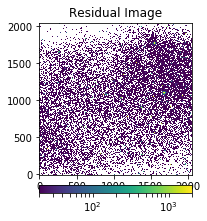

In [47]:
plt.subplots()
plt.imshow(image_data, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower', norm=LogNorm(20,2000))
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,2, 2)
plt.imshow(residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower', norm=LogNorm(20,2000))
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.05)


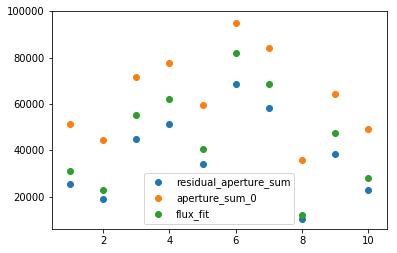

In [49]:
fig, ax = plt.subplots()
ax.scatter(total_table["id"], total_table["residual_aperture_sum"])
ax.scatter(total_table["id"], total_table["aperture_sum_0"])
#ax.scatter(result_tab["id"], result_tab["flux_0"])
ax.scatter(result_tab["id"], result_tab["flux_fit"])
plt.legend()
plt.show()